(sec:cnn)=
# Convolutional Neural Networks

Convolutional Neural Networks (_aka_ ConvNets) are designed to take advantage of the structure in the data.
In this chapter, we will discuss two flavours of ConvNets: we will start with the monodimensional case and see how ConvNets with 1D convolutions can be helpful to process time series and we will then introduce the 2D case that is especially useful to process image data.

## ConvNets for time series

Convolutional neural networks for time series rely on the
1D convolution operator that, given a time series $\mathbf{x}$ and a filter
$\mathbf{f}$, computes an activation map as:

\begin{equation}
    \left(\mathbf{x} * \mathbf{f}\right)(t) = \sum_{k=-L}^L f_{k} x_{t + k} \label{eq:conv1d}
\end{equation}

where the filter $\mathbf{f}$ is of length $(2L + 1)$.

The following code illustrates this notion using a Gaussian filter:

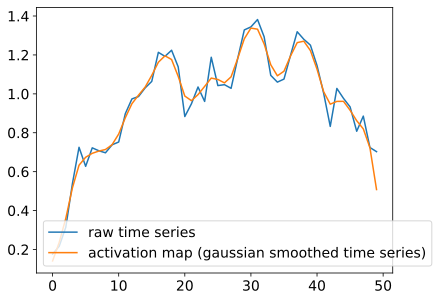

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from notebook_utils import prepare_notebook_graphics
prepare_notebook_graphics()

import numpy as np

def random_walk(size):
    rnd = np.random.randn(size) * .1
    ts = rnd
    for t in range(1, size):
        ts[t] += ts[t - 1]
    return ts

np.random.seed(0)
x = random_walk(size=50)
f = np.exp(- np.linspace(-2, 2, num=5) ** 2 / 2)
f /= f.sum()

plt.figure()
plt.plot(x, label='raw time series')
plt.plot(np.correlate(x, f, mode='same'),
         label='activation map (gaussian smoothed time series)')
plt.legend();

Convolutional neural networks are made of convolution blocks whose parameters
are the coefficients of the filters they embed (hence filters are not fixed
    _a priori_ as in the example above but rather learned).
These convolution blocks are translation equivariant, which means that a
(temporal) shift in their input results in the same temporal shift in the
output:

In [2]:
from IPython.display import HTML
from celluloid import Camera

f = np.zeros((12, ))
f[:4] = -1.
f[4:8] = 1.
f[8:] = -1.

length = 60

fig = plt.figure()
camera = Camera(fig)

for pos in list(range(5, 35)) + list(range(35, 5, -1)):
    x = np.zeros((100, ))
    x[pos:pos+length] = np.sin(np.linspace(0, 2 * np.pi, num=length))

    act = np.correlate(x, f, mode='same')

    plt.subplot(2, 1, 1)
    plt.plot(x, 'b-')
    plt.title("Input time series")
    fig2 = plt.subplot(2, 1, 2)
    plt.plot(act, 'r-')
    plt.title("Activation map")

    axes2 = fig.add_axes([.15, .35, 0.2, 0.1]) # renvoie un objet Axes
    axes2.plot(f, 'k-')
    axes2.set_xticks([])
    axes2.set_title("Filter")

    plt.tight_layout()
    camera.snap()

anim = camera.animate()
plt.close()

HTML(anim.to_jshtml())

/tmp/ipykernel_5089/368849627.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_5089/368849627.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  fig2 = plt.subplot(2, 1, 2)


Convolutional models are known to perform very well in computer vision
applications, using moderate amounts of parameters compared to fully connected
ones (of course, counter-examples exist, and the term "moderate" is
especially vague).

Most standard time series architectures that rely on convolutional blocks
are straight-forward adaptations of
models from the computer vision community
({cite:p}`leguennec:halshs-01357973` relies on an
old-fashioned alternance between convolution and pooling layers,
while more recent works rely on residual connections and
inception modules {cite:p}`fawaz2020inceptiontime`).
These basic blocks (convolution, pooling, residual layers) are discussed 
in more details in the next Section.

These time series classification models (and more) are presented and 
benchmarked in {cite:p}`fawaz2019deep` that we
advise the interested reader to refer to for more details.

## Convolutional neural networks for images

We now turn our focus to the 2D case, in which our convolution 
filters will not slide on a single axis as in the time series case but rather 
on the two dimensions (width and height) of an image.

### Images and convolutions

As seen below, an image is a pixel grid, and each pixel has an intensity value in each of the image channels. 
Color images are typically made of 3 channels (Red, Green and Blue here).

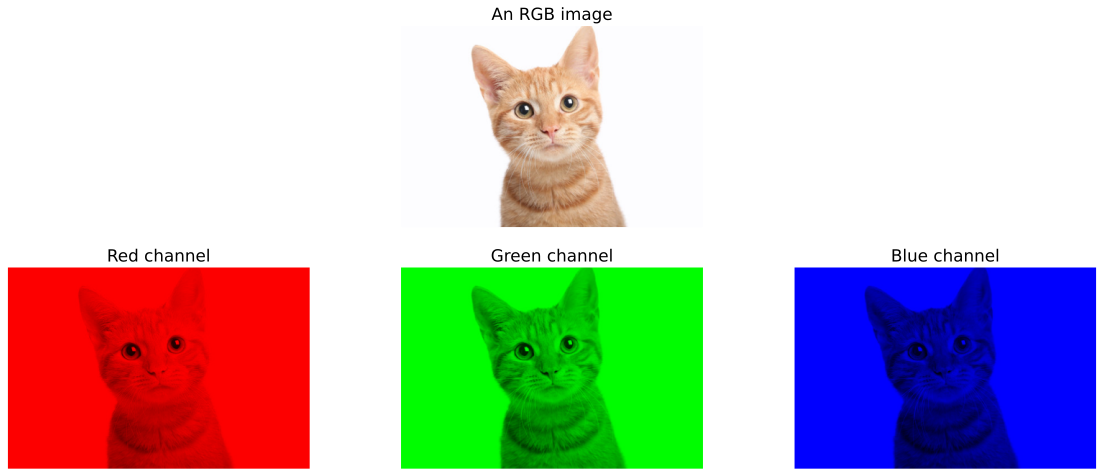

In [3]:
from matplotlib import image

image = image.imread('../data/cat.jpg')
image_r = image.copy()
image_g = image.copy()
image_b = image.copy()
image_r[:, :, 1:] = 0.
image_g[:, :, 0] = 0.
image_g[:, :, -1] = 0.
image_b[:, :, :-1] = 0.

plt.figure(figsize=(20, 8))
plt.subplot(2, 3, 2)
plt.imshow(image)
plt.title("An RGB image")
plt.axis("off")

for i, (img, color) in enumerate(zip([image_r, image_g, image_b],
                                     ["Red", "Green", "Blue"])):
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(f"{color} channel")
    plt.axis("off")

The output of a convolution on an image $\mathbf{x}$ is a new image, whose pixel values can be computed as:

\begin{equation}
    \left(\mathbf{x} * \mathbf{f}\right)(i, j) = \sum_{k=-K}^K \sum_{l=-L}^L \sum_{c=1}^3 f_{k, l, c} x_{i + k, j + l, c} . \label{eq:conv2d}
\end{equation}

In other words, the output image pixels are computed as the dot product between a convolution filter (which is a tensor of shape $(2K + 1, 2L + 1, c)$) and the image patch centered at the given position.

Let us, for example, consider the following 9x9 convolution filter:

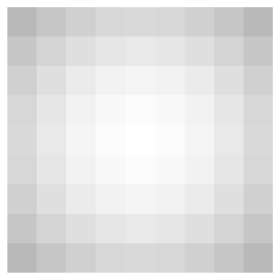

In [4]:
sz = 9

filter = np.exp(-(((np.arange(sz) - (sz - 1) // 2) ** 2).reshape((-1, 1)) + ((np.arange(sz) - (sz - 1) // 2) ** 2).reshape((1, -1))) / 100.)
filter_3d = np.zeros((sz, sz, 3))
filter_3d[:] = filter.reshape((sz, sz, 1))


plt.figure()
plt.imshow(filter_3d)
plt.axis("off");

Then the output of the convolution of the cat image above with this filter is the following greyscale (_ie._ single channel) image:

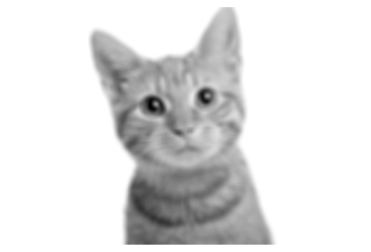

In [5]:
from scipy.signal import convolve2d

convoluted_signal = np.zeros(image.shape[:-1])
for c in range(3):
    convoluted_signal += convolve2d(image[:, :, c], filter_3d[:, :, c], mode="same", boundary="symm")

plt.figure()
plt.imshow(convoluted_signal, cmap="gray")
plt.axis("off");

One might notice that this image is a blurred version of the original image.
This is because we used a Gaussian filter in the process.
As for time series, when using convolution operations in neural networks, the contents of the filters will be learnt, rather than set _a priori_.

### CNNs _à la_ LeNet

In {cite:p}`lecun1998gradient`, a stack of convolution, pooling and fully connected layers is introduced for an image classification task, more specifically a digit recognition application.
The resulting neural network, called LeNet, is depicted below:

```{figure} ../img/lenet.png
:name: fig-lenet

LeNet-5 model
```

#### Convolution layers

A convolution layer is made of several convolution filters (also called _kernels_) that operate in parallel on the same input image.
Each convolution filter generates an output activation map and all these maps are stacked (in the channel dimension) to form the output of the convolution layer.
All filters in a layer share the same width and height.
A bias term and an activation function can be used in convolution layers, as in other neural network layers.
All in all, the output of a convolution filter is computed as:

\begin{equation}
    \left(\mathbf{x} * \mathbf{f}\right)(i, j, c) = \varphi \left( \sum_{k=-K}^K \sum_{l=-L}^L \sum_{c^\prime} f^c_{k, l, c^\prime} x_{i + k, j + l, c^\prime} + b_c \right) \label{eq:conv_layer}
\end{equation}

where $c$ denotes the output channel (note that each output channel is associated with a filter $f^c$), $b_c$ is its associated bias term and $\varphi$ is the activation function to be used.

````{tip}
In `keras`, such a layer is implemented using the `Conv2D` class:

```python
from tensorflow.keras.layers import Conv2D

layer = Conv2D(filters=6, kernel_size=5, padding="valid", activation="relu")
```
````


`````{admonition} Padding

````{subfigure} AB
:name: fig-padding
:subcaptions: above

```{image} ../img/no_padding_no_strides.gif
```

```{image} ../img/same_padding_no_strides.gif
```

A visual explanation of padding (source: [V. Dumoulin, F. Visin - A guide to convolution arithmetic for deep learning](https://github.com/vdumoulin/conv_arithmetic)).
Left: Without padding, right: With padding.
````

When processing an input image, it can be useful to ensure that the output feature map has the same width and height as the input image.
This can be achieved by padding the input image with surrounding zeros, as illustrated in {numref}`fig-padding` in which the padding area is represented in white.
`````

#### Pooling layers

Pooling layers perform a subsampling operation that somehow summarizes the information contained in feature maps in lower resolution maps.

The idea is to compute, for each image patch, an output feature that computes an aggregate of the pixels in the patch.
Typical aggregation operators are average (in this case the corresponding layer is called an average pooling layer) or maximum (for max pooling layers) operators.
In order to reduce the resolution of the output maps, these aggregates are typically computed on sliding windows that do not overlap, as illustrated below, for a max pooling with a pool size of 2x2:

```{tikz}
\filldraw[fill=gray!20, draw=black] (0,0) rectangle (2,2);
\filldraw[fill=gray!40, draw=black] (0,2) rectangle (2,4);
\filldraw[fill=gray!20, draw=black] (0,4) rectangle (2,6);
\filldraw[fill=gray!40, draw=black] (0,6) rectangle (2,8);

\filldraw[fill=gray!30, draw=black] (2,0) rectangle (4,2);
\filldraw[fill=gray!50, draw=black] (2,2) rectangle (4,4);
\filldraw[fill=gray!60, draw=black] (2,4) rectangle (4,6);
\filldraw[fill=gray!70, draw=black] (2,6) rectangle (4,8);

\filldraw[fill=gray!80, draw=black] (4,0) rectangle (6,2);
\filldraw[fill=gray!20, draw=black] (4,2) rectangle (6,4);
\filldraw[fill=gray!30, draw=black] (4,4) rectangle (6,6);
\filldraw[fill=gray!10, draw=black] (4,6) rectangle (6,8);

\filldraw[fill=gray!90, draw=black] (6,0) rectangle (8,2);
\filldraw[fill=gray!10, draw=black] (6,2) rectangle (8,4);
\filldraw[fill=gray!20, draw=black] (6,4) rectangle (8,6);
\filldraw[fill=gray!30, draw=black] (6,6) rectangle (8,8);

\filldraw[fill=gray!50, draw=black, line width=2] (12,2) rectangle (14,4);
\filldraw[fill=gray!70, draw=black, line width=2] (12,4) rectangle (14,6);
\filldraw[fill=gray!90, draw=black, line width=2] (14,2) rectangle (16,4);
\filldraw[fill=gray!30, draw=black, line width=2] (14,4) rectangle (16,6);

\draw[line width=2] (0,0) rectangle (4,4);
\draw[line width=2] (4,4) rectangle (8,8);
\draw[line width=2] (0,4) rectangle (4,8);
\draw[line width=2] (4,0) rectangle (8,4);

\node[draw,circle,minimum size=25pt,inner sep=0pt] (max) at (10, 7) {max};
\draw[->] (1,7) to[in=140,out=80] node {} (max);
\draw[->] (3,7) to[in=160,out=70] node {} (max);
\draw[->] (1,5) to[in=210,out=280] node {} (max);
\draw[->] (3,5) to[in=190,out=290] node {} (max);
\draw[->] (max) to node{} (13,5);
```

Such layers were widely used in the early years of convolutional models and are now less and less used as the available amount of computational power grows.

````{tip}
In `keras`, pooling layers are implemented through the `MaxPool2D` and `AvgPool2D` classes:

```python
from tensorflow.keras.layers import MaxPool2D, AvgPool2D

max_pooling_layer = MaxPool2D(pool_size=2)
average_pooling_layer = AvgPool2D(pool_size=2)
```
````


#### Plugging fully-connected layers at the output

A stack of convolution and pooling layers outputs a structured activation map (that takes the form of 2d grid with an additional channel dimension).
When image classification is targeted, the goal is to output the most probable class for the input image, which is usually performed by a classification head that consists in fully-connected layers.

In order for the classification head to be able to process an activation map, information from this map needs to be transformed into a vector.
This operation is called flattening in `keras`, and the model corresponding to {numref}`fig-lenet` can be implemented as:

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=5, padding="valid", activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(filters=16, kernel_size=5, padding="valid", activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(120, activation="relu"),
    Dense(84, activation="relu"),
    Dense(10, activation="softmax")
])
model.summary()

2023-02-06 22:53:15.751129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-02-06 22:53:16.301330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 22:53:16.301361: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-06 22:53:17.748753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 22:53:17.748879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 22:53:17.748890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 28, 28, 6)         156       


 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      


 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         


 2D)                                                             


 flatten (Flatten)           (None, 400)               0         


 dense (Dense)               (None, 120)               48120     


 dense_1 (Dense)             (None, 84)                10164     


 dense_2 (Dense)             (None, 10)                850       


Total params: 61,706


Trainable params: 61,706


Non-trainable params: 0


_________________________________________________________________


2023-02-06 22:53:19.396102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 22:53:19.396760: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 22:53:19.396792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az559-714): /proc/driver/nvidia/version does not exist
2023-02-06 22:53:19.397852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<!-- ### Anatomy of a ResNet

### Using a pre-trained model for better performance -->

## References

```{bibliography}
:filter: docname in docnames
```